# Pytemoics Practice - 05/15/2020

### The following script utilizes Python & Pyteomics to: 
1. find and open/read a thermo-fisher .raw 'peptide map' data file
2. read in a fasta file with one protein sequence
3. 'digest' the sequence with trypsin
4. calculate the masses of tryptic peptides; 
5. calculate the mass-to-charge of all tryptic peptides assuming that they are ionized with +1 to +3 charge states
6. "Search" the peptide map data for each ion;  
7. answer 'how many of the amino acids (% of total) in your protein did you identify?'
8. answer 'does this % change if you use a different file?'

In [1]:
import os
from urllib.request import urlretrieve
import gzip
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyteomics import fasta, parser, mass, achrom, electrochem, auxiliary

In [2]:
# This code is from a Pyteomics example thats downloads a FASTA database. I was not able to run the code
# - I receive an error of 'fails to change directory'. Instead, I downloaded the same file from the website 
# and accessed it from my computer, rather than downloading directly from the server. 

#if not os.path.isfile('yeast.fasta.gz'):
#    print 'Downloading the FASTA file for Saccharomyces cerevisiae...'
#    urlretrieve(
#        'ftp://ftp.uniprot.org/pub/databases/uniprot/current_release/'
#        'knowledgebase/proteomes/YEAST.fasta.gz',
#        'yeast.fasta.gz')
#    print 'Done!'

Example: https://pyteomics.readthedocs.io/en/stable/examples/example_fasta.html

### <font color='blue'> 1) Find and open/read a thermo-fisher .raw 'peptide map' data file </font>

In [3]:
# TBD - see email

I had a hard time finding publically accesible .raw files, but I was able to practice peptide digestion and calculations on fasta files from UniProt: https://www.uniprot.org

In [4]:
# This is how to open/read a FASTA file and print the heading.

with fasta.read('/Users/sarahkurpiers/Documents/Genentech/yeast.fasta') as yeast:
    print(next(yeast).description)

sp|A0A023PYF4|YE145_YEAST Uncharacterized protein YER145C-A OS=Saccharomyces cerevisiae (strain ATCC 204508 / S288c) (Baker's yeast) OX=559292 GN=SGD:S000028758 PE=3 SV=1


# Part 1: Analyzing an entire FASTA file

This sections analyzes the entire Fasta file for the Baker's yeast proteome - Saccharomyces cerevisiae (strain ATCC 204508 / S288c). Analysis is limited to sequences with less than 100 residues to save time. Future sections focus on just one protein. Here is the link to data used: https://www.uniprot.org/proteomes/UP000002311

In [5]:
# Cleave entire set of proteins and count number of sequences
print('Cleaving the proteins with trypsin...')
unique_peptides = set()
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/yeast.fasta') as yeast:
    for descr, seq in yeast:
        new_peptides = parser.cleave(seq, parser.expasy_rules['trypsin'])
        unique_peptides.update(new_peptides)
print('Done, {0} sequences obtained!'.format(len(unique_peptides)))

Cleaving the proteins with trypsin...
Done, 188694 sequences obtained!


In [6]:
# Create dict of peptides
peptides = [{'sequence': i} for i in unique_peptides]

# Pre-parse the sequence into individual amino acids, save terminal groups to take into account in mass & charge
# Add sequence and parsed sequence to dict
for peptide in peptides:
    peptide['parsed_sequence'] = parser.parse(peptide['sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    
# Limit to peptides with less than 100 residues
peptides = [peptide for peptide in peptides if peptide['length'] <= 100]

In [7]:
# Add properties to dict including: charge with pH = 2.0, mass, m/z, and 
# retention time in reversed and normal phase chromatography
for peptide in peptides:
    peptide['charge'] = int(round(electrochem.charge(peptide['parsed_sequence'], pH=2.0)))
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['m/z'] = mass.calculate_mass(peptide['parsed_sequence'], charge=peptide['charge'])
    peptide['RT_RP'] = achrom.calculate_RT(peptide['parsed_sequence'],achrom.RCs_zubarev)
    peptide['RT_normal'] = achrom.calculate_RT(peptide['parsed_sequence'],achrom.RCs_yoshida_lc)

# Create dataframe to store peptide properties in
peptidedf = pd.DataFrame.from_dict(peptides)
peptidedf.head(5)

,RT_RP,RT_normal,charge,length,m/z,mass,parsed_sequence,sequence
0,8.348433,18.363284,3,5,215.094249,642.260919,"[H-, H, D, D, E, K, -OH]",HDDEK
1,25.639098,11.391755,2,7,359.708328,717.402104,"[H-, V, T, G, N, I, S, K, -OH]",VTGNISK
2,35.754229,10.134338,2,8,446.221277,890.428001,"[H-, V, N, G, I, S, M, D, R, -OH]",VNGISMDR
3,53.569863,10.413623,2,11,627.316625,1252.618698,"[H-, L, A, L, D, S, Y, I, S, E, D, K, -OH]",LALDSYISEDK
4,23.876233,10.619276,2,6,350.192845,698.371138,"[H-, E, Q, P, G, L, R, -OH]",EQPGLR


# Part 2, One Protein Sequence: Protein 1

To answer your questions, I chose the first sequence from the Baker's yeast proteome by indexing a dataframe of all of the sequences.

### <font color='blue'> 2) Read in a fasta file with just one protein sequence  </font> 

In [8]:
unique_proteins1 = []
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/yeast.fasta') as yeast:
    for descr, seq in yeast:
        unique_proteins1.append(seq)
proteindf1 = pd.DataFrame(unique_proteins1, columns = ['Sequence'])
protein1 = proteindf1.iloc[0,0]
protein1

'MAILLPLKSILPWCCITFSFLLSSSGSISHSTASSSITLTKSSKPTNVPSNSRFDCSTINTFWLIVLSMTSKGKISGRLILRASVYACECTCIRYACCETIYPPRKPFSLSLYFFYFNKKASILFCYPDAKTKPEHPGNKRAGSG'

### <font color='blue'> 3) 'Digest' the sequence with trypsin  </font> 

In [9]:
# 'Digest' the sequence with trypsin
unique_peptides1 = set()
new_peptides1 = parser.cleave(protein1, parser.expasy_rules['trypsin'])
unique_peptides1.update(new_peptides1)
unique_peptides1

{'AGSG',
 'ASILFCYPDAK',
 'ASVYACECTCIR',
 'FDCSTINTFWLIVLSMTSK',
 'GK',
 'ISGR',
 'K',
 'KPFSLSLYFFYFNK',
 'LILR',
 'MAILLPLK',
 'R',
 'SILPWCCITFSFLLSSSGSISHSTASSSITLTK',
 'SSKPTNVPSNSR',
 'TKPEHPGNK',
 'YACCETIYPPR'}

In [10]:
# Create dict of peptides
peptides1 = [{'Sequence': i} for i in unique_peptides1]

### <font color='blue'> 4) Calculate the masses of tryptic peptides  </font> 

In [11]:
# Calculate the masses of tryptic peptides and assign to dataframe
for peptide in peptides1:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass1 = pd.DataFrame(peptides1)
columns_to_keep = ['Sequence', 'Mass']
peptidemass1 = peptidemass1[columns_to_keep]
peptidemass1 = peptidemass1.set_index('Sequence')
peptidemass1

,Mass
Sequence,
SSKPTNVPSNSR,1272.642227
ISGR,431.249232
LILR,513.363868
KPFSLSLYFFYFNK,1799.928679
AGSG,290.122634
TKPEHPGNK,1006.519593
ASVYACECTCIR,1317.551564
YACCETIYPPR,1314.573679
SILPWCCITFSFLLSSSGSISHSTASSSITLTK,3460.725829


### <font color='blue'> 5) Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states  </font> 

In [12]:
# Create dataframe with mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides1:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz1 = pd.DataFrame(peptides1)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz1 = peptidemz1[columns_to_keep]
peptidemz1 = peptidemz1.set_index('Sequence')
peptidemz1

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
SSKPTNVPSNSR,1272.642227,1273.649504,637.328390,425.221352
ISGR,431.249232,432.256508,216.631892,144.757020
LILR,513.363868,514.371144,257.689210,172.128566
KPFSLSLYFFYFNK,1799.928679,1800.935956,900.971616,600.983503
AGSG,290.122634,291.129911,146.068594,97.714821
TKPEHPGNK,1006.519593,1007.526869,504.267073,336.513807
ASVYACECTCIR,1317.551564,1318.558840,659.783058,440.191131
YACCETIYPPR,1314.573679,1315.580956,658.294116,439.198503
SILPWCCITFSFLLSSSGSISHSTASSSITLTK,3460.725829,3461.733106,1731.370191,1154.582553


### <font color='blue'> 6) 'Search' the peptide map data for each ion </font>  

In [13]:
# TBD

### <font color='blue'> 7) How many amino acids (% of total) are in the protein? </font>  

In [14]:
# Determine amino acid composition of the protein
aacomp1 = parser.amino_acid_composition(protein1)
aacomp1

BasicComposition({'M': 2, 'A': 8, 'I': 12, 'L': 14, 'P': 10, 'K': 11, 'S': 24, 'W': 2, 'C': 9, 'T': 11, 'F': 9, 'G': 6, 'H': 2, 'N': 5, 'V': 3, 'R': 6, 'D': 2, 'Y': 6, 'E': 3})

In [15]:
type(aacomp1)

pyteomics.auxiliary.structures.BasicComposition

In [16]:
# Split dictionary into keys and values
aakeys1 = aacomp1.keys() 
aavalues1 = aacomp1.values()

# Create DataFrame for amino acids in protein
aacompdf1 = pd.DataFrame(aavalues1, index = aakeys1)
aacompdf1 = aacompdf1.rename_axis('Yeast Protein 1 Amino Acids')
aacompdf1 = aacompdf1.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf1['% of Total'] = (aacompdf1['Number of Residues'])/(aacompdf1['Number of Residues'].sum())*100
aacompdf1

,Number of Residues,% of Total
Yeast Protein 1 Amino Acids,,
M,2,1.379310
A,8,5.517241
I,12,8.275862
L,14,9.655172
P,10,6.896552
K,11,7.586207
S,24,16.551724
W,2,1.379310
C,9,6.206897


### <font color='blue'> 8) Does this % change if you use a different file? </font>  

Yes, the % of each amino acid changes using different files. See below:

## Protein 2
#### I repeated the pocess using E.Coli and selecting the first protein sequence. Here is the link to Escherichia coli (strain K12) data used: https://www.uniprot.org/proteomes/UP000000625

In [17]:
# Read in a fasta file with just one protein sequence
unique_proteins2 = []
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/ECOLI.fasta') as ecoli:
    for descr, seq in ecoli:
        unique_proteins2.append(seq)
proteindf2 = pd.DataFrame(unique_proteins2, columns = ['Sequence'])
ecoliprotein1 = proteindf2.iloc[0,0]
ecoliprotein1

'MPVLQWGMLCVLSLLLSIGFLAVHLPAALLLGPMIAGIIFSMRGITLQLPRSAFLAAQAILGCMIAQNLTGSILTTLAVNWPIVLAILLVTLLSSAIVGWLLVRYSSLPGNTGAWGSSPGGAAAMVAMAQDYGADIRLVAFMQYLRVLFVAGAAVLVTRMMLGDNAEAVNQHIVWFPPVSINLLLTILLAVVAGTVGCLLRLPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWRIGLGFDKQILLRALRPLPQILLSIFALLAICAGMAWGLTRFMHIDFMTAYLATSPGGLDTVAVIAAGSNADMALIMAMQTLRLFSILLTGPAIARFISTYAPKRSA'

In [18]:
# 'Digest' the sequence with trypsin
unique_peptides2 = set()
new_peptides2 = parser.cleave(ecoliprotein1, parser.expasy_rules['trypsin'])
unique_peptides2.update(new_peptides2)
unique_peptides2

{'ALRPLPQILLSIFALLAICAGMAWGLTR',
 'FISTYAPK',
 'FMHIDFMTAYLATSPGGLDTVAVIAAGSNADMALIMAMQTLR',
 'GITLQLPR',
 'IGLGFDK',
 'LFSILLTGPAIAR',
 'LPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWR',
 'LVAFMQYLR',
 'MMLGDNAEAVNQHIVWFPPVSINLLLTILLAVVAGTVGCLLR',
 'MPVLQWGMLCVLSLLLSIGFLAVHLPAALLLGPMIAGIIFSMR',
 'QILLR',
 'R',
 'SA',
 'SAFLAAQAILGCMIAQNLTGSILTTLAVNWPIVLAILLVTLLSSAIVGWLLVR',
 'VLFVAGAAVLVTR',
 'YSSLPGNTGAWGSSPGGAAAMVAMAQDYGADIR'}

In [19]:
# Create dict of peptides
peptides2 = [{'Sequence': i} for i in unique_peptides2]

In [20]:
# Calculate the masses of tryptic peptides
for peptide in peptides2:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass2 = pd.DataFrame(peptides2)
columns_to_keep = ['Sequence', 'Mass']
peptidemass2 = peptidemass2[columns_to_keep]
peptidemass2 = peptidemass2.set_index('Sequence')
peptidemass2.head(4)

,Mass
Sequence,
LPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWR,4454.364222
MMLGDNAEAVNQHIVWFPPVSINLLLTILLAVVAGTVGCLLR,4500.446312
ALRPLPQILLSIFALLAICAGMAWGLTR,3007.723132
YSSLPGNTGAWGSSPGGAAAMVAMAQDYGADIR,3228.460447


In [21]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 to +3 charge states
for peptide in peptides2:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz2 = pd.DataFrame(peptides2)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz2 = peptidemz2[columns_to_keep]
peptidemz2 = peptidemz2.set_index('Sequence')
peptidemz2.head(4)

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
LPSGTMLIPMLAGAVLQSGQLITIELPEWLLAMAYMAIGWR,4454.364222,4455.371498,2228.189387,1485.795350
MMLGDNAEAVNQHIVWFPPVSINLLLTILLAVVAGTVGCLLR,4500.446312,4501.453588,2251.230432,1501.156047
ALRPLPQILLSIFALLAICAGMAWGLTR,3007.723132,3008.730408,1504.868842,1003.581654
YSSLPGNTGAWGSSPGGAAAMVAMAQDYGADIR,3228.460447,3229.467723,1615.237500,1077.160759


In [22]:
# "Search" the peptide map data for each ion
# TBD

In [24]:
# How many amino acids (% of total) are in the protein?

# Determine amino acid composition of the protein
aacomp2 = parser.amino_acid_composition(ecoliprotein1)
aacomp2

# split dictionary into keys and values
aakeys2 = aacomp2.keys() 
aavalues2 = aacomp2.values()

# create DataFrame for amino acids in protein
aacompdf2 = pd.DataFrame(aavalues2, index = aakeys2)
aacompdf2 = aacompdf2.rename_axis('E.Coli Protein 1 Amino Acids')
aacompdf2 = aacompdf2.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf2['% of Total'] = (aacompdf2['Number of Residues'])/(aacompdf2['Number of Residues'].sum())*100
aacompdf2

,Number of Residues,% of Total
E.Coli Protein 1 Amino Acids,,
M,20,5.747126
P,17,4.885057
V,23,6.609195
L,63,18.103448
Q,12,3.448276
W,8,2.298851
G,30,8.620690
C,4,1.149425
S,20,5.747126


##### Finally, I used this process on a single protein FASTA, rather than selecting one protein from a full proteome file.

## Protein 3 - Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic

When using UniProt, the Fasta of just one protein downloads to a web archive file. This makes the heading hard to deal with, and it becomes a part of the sequence when trying to iterate (see first code box). To fix this, I stripped the characters from before and after the amino acid sequence. (This is not very efficient for future files, but I could not figure out a better way to deal with the format at the moment.) https://www.uniprot.org/uniprot/A6MML6

In [29]:
# Read in a fasta file with just one protein sequence
# add encoding = latin-1 to get rid of byte errors
with fasta.read('/Users/sarahkurpiers/Documents/Genentech/A6MML6.fasta', encoding='latin-1') as protein3:
    for descr, seq in protein3:
        print('From web:', seq)
seq = seq.strip('^WebResourceURL_WebResourceFrameName_WebResourceData_WebResourceMIMEType_WebResourceTextEncodingName_,https://www.uniprot.org/uniprot/A6MML6.fastaPOø<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">&gt;sp|A6MML6|ACCD_DIOEL Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic OS=Dioscorea elephantipes OX=145284 GN=accD PE=3 S')
seq = seq.rstrip('</body></html>Ztext/plainUUTF-8\x00\x08\x00\x00\x00(\x007\x00N\x00`\x00v\x00\x94\x00Ã\x00Ä\x03À\x03Ë\x00\x00\x00\x00\x00\x00\x02\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03Ñ')
seq = seq.strip('V=2')
seq = seq.rstrip('</pr')
print('')
print('Stripped sequence:', seq)

From web: ^WebResourceURL_WebResourceFrameName_WebResourceData_WebResourceMIMEType_WebResourceTextEncodingName_,https://www.uniprot.org/uniprot/A6MML6.fastaPOø<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">&gt;sp|A6MML6|ACCD_DIOEL Acetyl-coenzyme A carboxylase carboxyl transferase subunit beta, chloroplastic OS=Dioscorea elephantipes OX=145284 GN=accD PE=3 SV=2MEKWWWFNSILSNERLEHRYGLSKSMDSVNGIEYTKDPILNDTEKNILGWSDSSNYSFSTVDYLFEIRNIWSLISDDTFLVRDSNGDSYSVYFDIENQIFEIDNNSSFLGELESFFSSYLNRGSKNKYYHYMYDTQFSWNNHITNCIDSYLRFEIGISITSYISGDIVNYSDGYIYSFICTESVSSNESGSSSIRTSSNGSDFNMRENSNDSDINKKYRHLWVQCENCYGLNYKKFFRSKMNICEQCGYHLKMSSSDRIEVSIDPDTWDPMDEDMVSIDPIEFHSEEEPYRDRIDSYQRKTGLTEAIQTGIGQLNGIPIAIGVMDFQFMGGSMGSVVGEKITRLIEYATNESLPVIIVCASGGARMQEGSLSLMQMAKISSASYNYQSNKKLFYVSILTSPTTGGVTASFGMLGDVIIAEPNAYIAFAGKRVIEQTLNKTVPDGSQSAEYLFHKGLFDPIVPRNPLKGVLSELFQLHGFLPLNQNKKEN</pre></body></html>Ztext/plainUUTF-8    ( 7 N ` v  Ã ÄÀË                           Ñ

Stripp

In [30]:
# 'Digest' the sequence with trypsin
print('Cleaving the protein with trypsin...')
unique_peptides3 = set()
new_peptides3 = parser.cleave(seq, parser.expasy_rules['trypsin'])
unique_peptides3.update(new_peptides3)
print('Done, {0} sequences obtained!'.format(len(unique_peptides3)))
unique_peptides3

Cleaving the protein with trypsin...
Done, 38 sequences obtained!


{'DPILNDTEK',
 'DR',
 'DSNGDSYSVYFDIENQIFEIDNNSSFLGELESFFSSYLNR',
 'EN',
 'ENSNDSDINK',
 'FEIGISITSYISGDIVNYSDGYIYSFICTESVSSNESGSSSIR',
 'FFR',
 'GLFDPIVPR',
 'GSK',
 'GVLSELFQLHGFLPLNQNK',
 'HLWVQCENCYGLNYK',
 'IDSYQR',
 'IEVSIDPDTWDPMDEDMVSIDPIEFHSEEEPYR',
 'ISSASYNYQSNK',
 'ITR',
 'K',
 'LEHR',
 'LFYVSILTSPTTGGVTASFGMLGDVIIAEPNAYIAFAGK',
 'LIEYATNESLPVIIVCASGGAR',
 'MEK',
 'MNICEQCGYHLK',
 'MQEGSLSLMQMAK',
 'MSSSDR',
 'NILGWSDSSNYSFSTVDYLFEIR',
 'NIWSLISDDTFLVR',
 'NK',
 'NPLK',
 'R',
 'SK',
 'SMDSVNGIEYTK',
 'TGLTEAIQTGIGQLNGIPIAIGVMDFQFMGGSMGSVVGEK',
 'TSSNGSDFNMR',
 'TVPDGSQSAEYLFHK',
 'VIEQTLNK',
 'WWWFNSILSNER',
 'YGLSK',
 'YR',
 'YYHYMYDTQFSWNNHITNCIDSYLR'}

In [31]:
# Create dict of peptides
peptides3 = [{'Sequence': i} for i in unique_peptides3]

In [32]:
# Calculate the masses of tryptic peptides
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['mass'] = mass.calculate_mass(peptide['parsed_sequence'])
peptidemass3 = pd.DataFrame(peptides3)
columns_to_keep = ['Sequence', 'mass']
peptidemass3 = peptidemass3[columns_to_keep]
peptidemass3 = peptidemass3.set_index('Sequence')
peptidemass3.head(4)

,mass
Sequence,
DPILNDTEK,1043.513505
VIEQTLNK,943.533846
MNICEQCGYHLK,1437.620312
IDSYQR,780.376617


In [33]:
# Calculate the mass-to-charge of all tryptic peptides assuming they are ionized with +1 and +3 charge states
for peptide in peptides3:
    peptide['parsed_sequence'] = parser.parse(peptide['Sequence'],show_unmodified_termini=True)
    peptide['length'] = parser.length(peptide['parsed_sequence']) 
    peptide['Mass'] = mass.calculate_mass(peptide['parsed_sequence'])
    peptide['M/z +1 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=1)
    peptide['M/z +2 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=2)
    peptide['M/z +3 charge state'] = mass.calculate_mass(peptide['parsed_sequence'], charge=3)
peptidemz3 = pd.DataFrame(peptides3)
columns_to_keep = ['Sequence', 'Mass', 'M/z +1 charge state', 'M/z +2 charge state', 'M/z +3 charge state']
peptidemz3 = peptidemz3[columns_to_keep]
peptidemz3 = peptidemz3.set_index('Sequence')
peptidemz3.head(4)

,Mass,M/z +1 charge state,M/z +2 charge state,M/z +3 charge state
Sequence,,,,
DPILNDTEK,1043.513505,1044.520781,522.764029,348.845111
VIEQTLNK,943.533846,944.541123,472.774200,315.518558
MNICEQCGYHLK,1437.620312,1438.627589,719.817433,480.214047
IDSYQR,780.376617,781.383894,391.195585,261.132816


In [34]:
# "Search" the peptide map data for each ion

In [35]:
# TBD

In [36]:
# How many amino acids (% of total) are in the protein?

# Determine amino acod composition
aacomp3 = parser.amino_acid_composition(seq)
aacomp3

# Split dictionary into keys and values
aakeys3 = aacomp3.keys() 
aavalues3 = aacomp3.values()

# Sreate DataFrame for amino acids in protein
aacompdf3 = pd.DataFrame(aavalues3, index = aakeys3)
aacompdf3 = aacompdf3.rename_axis('Acetyl-coenzyme A Amino Acids')
aacompdf3 = aacompdf3.rename(columns={0: 'Number of Residues'})

# Calculate individual amino acid % of total
aacompdf3['% of Total'] = (aacompdf3['Number of Residues'])/(aacompdf3['Number of Residues'].sum())*100
aacompdf3

,Number of Residues,% of Total
Acetyl-coenzyme A Amino Acids,,
M,15,3.067485
E,32,6.543967
K,23,4.703476
W,8,1.635992
F,25,5.112474
N,36,7.361963
S,64,13.087935
I,43,8.793456
L,33,6.748466


In [50]:
from pyteomics import mgf, pepxml
import pylab

# Part 3: Reading in a MGF file and comparing to pepXML identification info

In [47]:
# Defines function that will give m/z of theoretical fragments for a given sequence. 
# pyteomics.mass.fast_mass() is used to calculate. The sequence is split at every bond and the function 
# iterates over possible charges and ion types

def fragments(peptide, types=('b', 'y'), maxcharge=3):
    """
    The function generates all possible m/z for fragments of types 
    `types` and of charges from 1 to `maxcharge`.
    """
    for i in xrange(1, len(peptide)-1):
        for ion_type in types:
            for charge in xrange(1, maxcharge+1):
                if ion_type[0] in 'abc':
                    yield mass.fast_mass(
                            peptide[:i], ion_type=ion_type, charge=charge)
                else:
                    yield mass.fast_mass(
                            peptide[i:], ion_type=ion_type, charge=charge)

In [44]:
with mgf.read('/Users/sarahkurpiers/Documents/Genentech/example.mgf') as spectra, pepxml.read('/Users/sarahkurpiers/Documents/Genentech/example.pep.xml') as psms:
    spectrum = next(spectra)
    psm = next(psms)
spectrum

{'params': {'title': 'GPAAIQK', 'pepmass': (342.70559, None), 'charge': [2]},
 'm/z array': array([155.08127, 176.77814, 177.11287, 226.11824, 229.64627, 265.16449,
        265.66641, 269.16089, 275.1712 , 297.15521, 314.19504, 314.69733,
        325.18619, 343.20746, 343.70929, 382.2438 , 388.25513, 389.25903,
        392.22888, 408.18784, 409.19104, 410.23959, 411.24402, 457.28772,
        459.29205, 460.29568, 493.27762, 513.3031 , 520.28723, 521.27124,
        522.27612, 530.32843, 531.33197, 532.33423, 536.24768, 538.29736,
        539.30054, 540.31415, 554.29248, 555.29999, 556.30743]),
 'intensity array': array([  2297.6,   7543.8,   2635.6,   5689.8,   5041.8,  17045.5,
          3543.8,   3408.9,   2846.8,   8410.6,   6265.5,   2129. ,
          3157.4,   4456.9,   4044.3,   3641.6,  42239.4,   6749.8,
          2317.6,   9400.2,   2566.7,  20488. ,   4645. ,   4824.5,
        139345.9,  35741.9,   3401.2,   6745.2,   2995.6,  10339.9,
          2187.7, 378102.2, 120362.4,   4

In [45]:
psm

{'spectrum': '',
 'precursor_neutral_mass': 683.3966,
 'assumed_charge': 2,
 'start_scan': 1,
 'end_scan': 1,
 'index': 1,
 'search_hit': [{'hit_rank': 1,
   'peptide': 'GPAAIQK',
   'num_tot_proteins': 1,
   'num_matched_ions': 8,
   'tot_num_ions': 12,
   'num_missed_cleavages': 0,
   'search_score': {'hyperscore': 23.2,
    'nextscore': 17.3,
    'bscore': 6.6,
    'yscore': 12.1,
    'cscore': 0.0,
    'zscore': 0.0,
    'ascore': 0.0,
    'xscore': 0.0,
    'expect': 1.3},
   'calc_neutral_pep_mass': 683.3966,
   'massdiff': 0.0,
   'is_rejected': False,
   'proteins': [{'protein': 'sp|P35527|K1C9_HUMAN',
     'protein_descr': 'Keratin, type I cytoskeletal 9 OS=Homo sapiens GN=KRT9 PE=1 SV=3',
     'peptide_next_aa': 'N',
     'peptide_prev_aa': 'K',
     'num_tol_term': 2}],
   'modified_peptide': 'GPAAIQK',
   'modifications': []}]}

<BarContainer object of 41 artists>

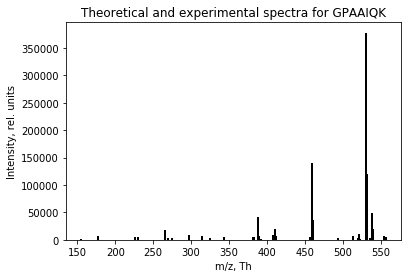

In [51]:
# Prepare figure
pylab.figure()
pylab.title('Theoretical and experimental spectra for '
        + psm['search_hit'][0]['peptide'])
pylab.xlabel('m/z, Th')
pylab.ylabel('Intensity, rel. units')

# Plot real spectrum
pylab.bar(spectrum['m/z array'], spectrum['intensity array'], width=0.1, linewidth=2,
        edgecolor='black')

In [55]:
try:
    # Python 2
    xrange
except NameError:
    # Python 3, xrange is now named range
    xrange = range

# Python 2 code that uses xrange(...) unchanged, and any
# range(...) replaced with list(range(...))

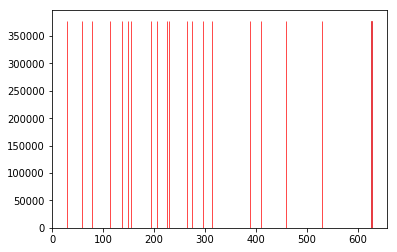

In [54]:
# The most intensive peaks in the spectrum are indeed matched by the theoretical spectrum
theor_spectrum = list(fragments(psm['search_hit'][0]['peptide'],
    maxcharge=psm['assumed_charge']))
pylab.bar(theor_spectrum,
        [spectrum['intensity array'].max()]*len(theor_spectrum),
        width=0.1, edgecolor='red', alpha=0.7)
pylab.show()